Linear Regression - MSE: 381077860.1748637, R²: 0.4490738048185411
Linear Regression with Feature Selection - MSE: 410168079.1097551, R²: 0.40701792776643086


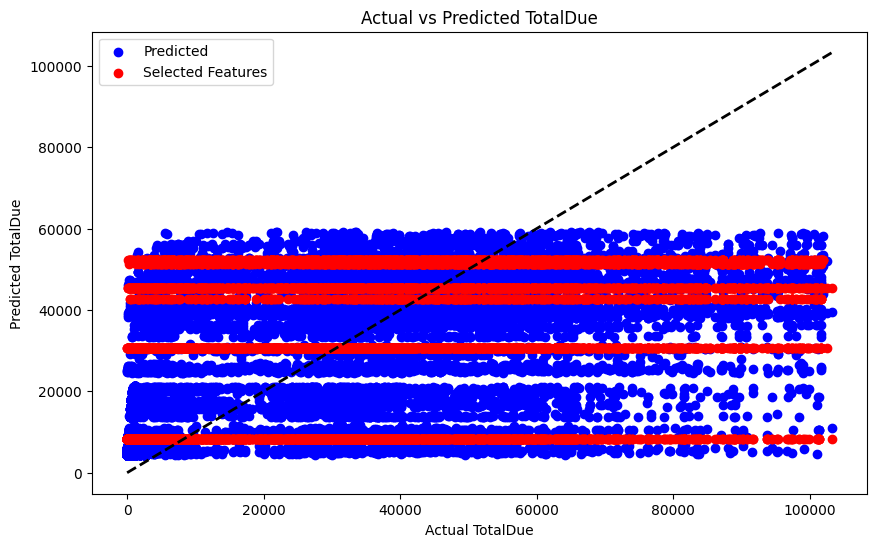

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import pyodbc
import matplotlib.pyplot as plt

connection_string = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-36TE5NO\SQLEXPRESS01;DATABASE=AdventureWorks2014;Trusted_Connection=yes;'
conn = pyodbc.connect(connection_string)

df = pd.read_sql_query('SELECT OrderQty, UnitPrice, TotalDue FROM Sales.SalesOrderHeader JOIN Sales.SalesOrderDetail ON SalesOrderHeader.SalesOrderID = SalesOrderDetail.SalesOrderID', conn)


Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_filtered = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

df_filtered.fillna(df_filtered.mean(), inplace=True)

X = df_filtered[['OrderQty', 'UnitPrice']]
y = df_filtered['TotalDue']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression - MSE: {mse}, R²: {r2}")

selector = RFE(model, n_features_to_select=2)
selector = selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)

mse_selected = mean_squared_error(y_test, y_pred_selected)
r2_selected = r2_score(y_test, y_pred_selected)
print(f"Linear Regression with Feature Selection - MSE: {mse_selected}, R²: {r2_selected}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.scatter(y_test, y_pred_selected, color='red', label='Selected Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual TotalDue')
plt.ylabel('Predicted TotalDue')
plt.title('Actual vs Predicted TotalDue')
plt.legend()
plt.show()
